# **Building Diffusion model**




## Investigating the dataset



In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define Project Folder
FOLDERNAME = 'Colab\ Notebooks/Diffusion_model'

%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Diffusion_model


In [ ]:
# Define device
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print('Device:', device)

Device: cuda


In [ ]:
import torchvision.transforms as T
import torchvision.datasets as dset
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
transforms = T.Compose([T.ToTensor(), T.Resize((32, 32))])

train = dset.MNIST('train_M', train=True, transform=transforms, download=True)
test = dset.MNIST('test_M', train=False, transform=transforms, download=True)

In [ ]:
train_dataloader = DataLoader(train, batch_size=8, shuffle=True, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Input shape: torch.Size([8, 1, 32, 32])
Labels: tensor([4, 8, 7, 0, 1, 7, 5, 7])


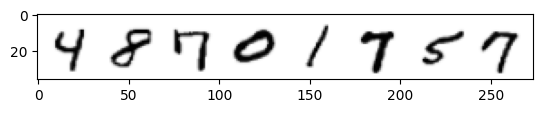

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

##The forward process (add noise)

In [ ]:
def corrupt(x, amount):
  noise = torch.rand_like(x)
  amount = amount.reshape(-1, 1, 1, 1)
  return x*(1-amount) + noise*amount, noise*amount

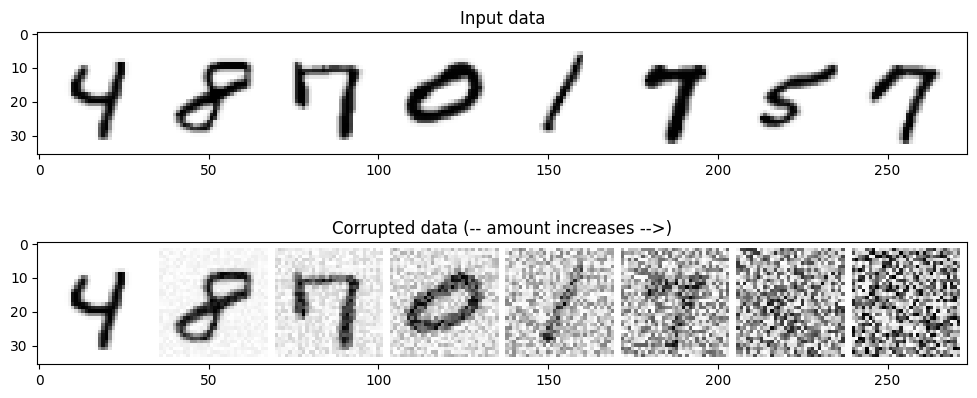

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
# x.shape => 8, 1, 32, 32
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x, noise = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

## The reverse process (U-Net)


In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels , out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
  def forward(self, x):
    return self.double_conv(x)

In [ ]:
class Unet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super().__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2, feature, 2, 2))
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, 1)

  def forward(self, x):
    skip_connections = []
    for down in self.downs:
      x = down(x) # 3 -> 64 -> 128 -> 256 -> 512
      skip_connections.append(x)
      x = F.max_pool2d(x, (2, 2))
    x = self.bottleneck(x)
    skip_connections.reverse()

    for i in range(0, len(self.ups), 2):
      x = self.ups[i](x)
      skip_connection = skip_connections[i//2]
      concat_x = torch.cat((skip_connection, x), dim=1)
      x = self.ups[i+1](concat_x)

    return self.final_conv(x)

In [ ]:
net = Unet(in_channels=1)
x = torch.rand(8, 1, 32, 32)
print(net(x).shape)

torch.Size([8, 1, 32, 32])


In [ ]:
sum([p.numel() for p in net.parameters()])

31036481

## Training

Finished epoch 1. Average loss for this epoch: 0.004852085771448195
Finished epoch 2. Average loss for this epoch: 0.001312404539736945
Finished epoch 3. Average loss for this epoch: 0.00108767718239042


(0.0, 0.1)

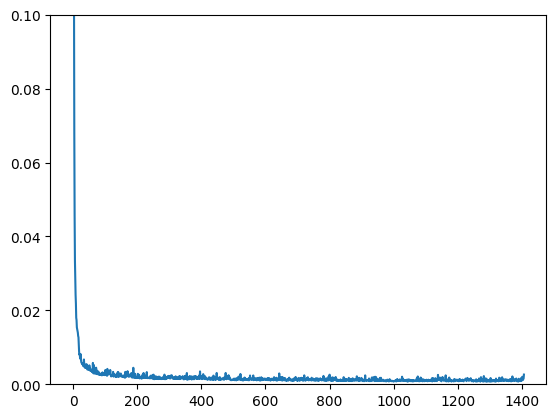

In [ ]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

net = Unet(in_channels=1)
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = optim.Adam(net.parameters())

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x, noise = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss valur for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):], )/len(train_dataloader)
    print(f"Finished epoch {epoch+1}. Average loss for this epoch: {avg_loss}")

# View the loss curve
plt.plot(losses)
plt.ylim(0.0, 0.1)

##Sampling

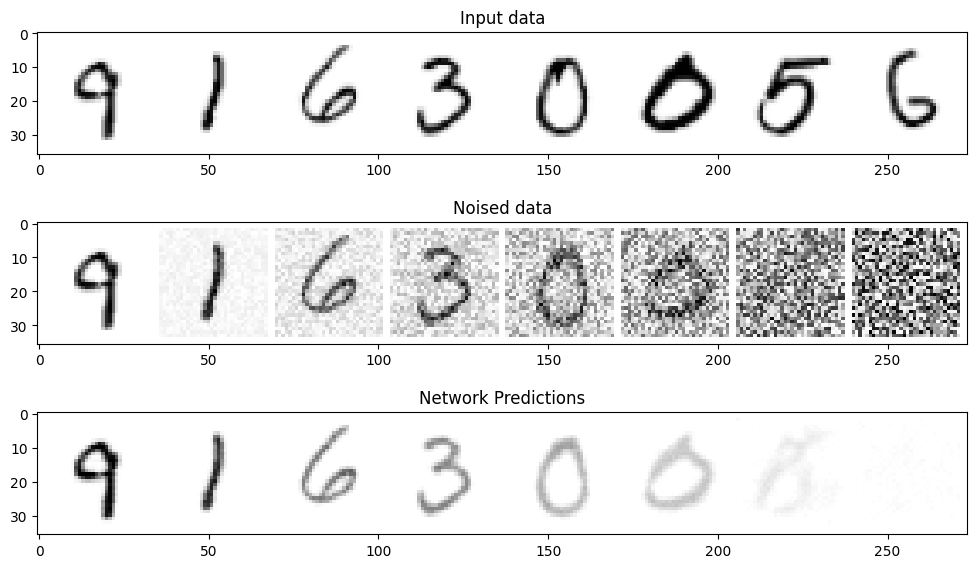

In [ ]:
# Fetch some data
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)
x, y = next(iter(test_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x, noise = corrupt(x, amount)

# Get the model predcitions
with torch.no_grad():
  preds = net((noised_x).to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Noised data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(noised_x-preds)[0].clip(0, 1), cmap='Greys')